In [ ]:
!pip install datasets

In [ ]:
import datasets
import pandas as pd
# Text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
# Modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional

In [ ]:
# pegar uma porcentagem do dataset de tal modo que as classes estejam balanceadas
def get_balanced_dataset(dataset, percentage):
    import warnings
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    dataset = pd.DataFrame(dataset)
    dataset = dataset[["Noticia", "Categoria", "label"]]
    dataset = dataset.groupby("Categoria").apply(lambda x: x.sample(frac=percentage)).reset_index(drop=True)
    return dataset

def selected_categories(row):
    return row["Categoria"] in ["Política", "Internacional", "Saúde", "Ciência e Tecnologia", "Economia"]

In [ ]:
dataset = datasets.load_dataset("recogna-nlp/recognasumm")

In [ ]:
len(set(dataset['train']['Categoria']))

24

In [ ]:
dataset = dataset.filter(selected_categories)

In [ ]:
Categories = ["Política", "Internacional", "Saúde", "Ciência e Tecnologia", "Economia"]
Categories

['Política', 'Internacional', 'Saúde', 'Ciência e Tecnologia', 'Economia']

In [ ]:
def catgeory2label(row):
    row["label"] = Categories.index(row["Categoria"])
    return row

In [ ]:
dataset = dataset.map(catgeory2label)

<Axes: title={'center': 'Distribuição das categorias'}, xlabel='Categoria'>

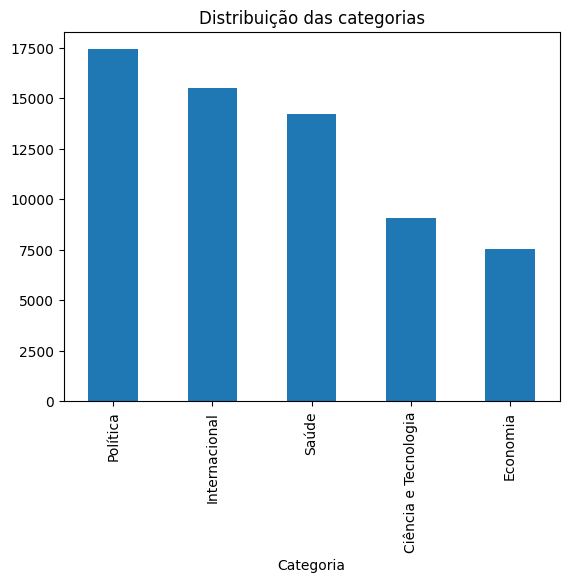

In [ ]:
pd.DataFrame(dataset['train'])['Categoria'].value_counts().plot(kind='bar', title='Distribuição das categorias')

In [ ]:
perc_train = 0.075
perc = 0.025

train_df = get_balanced_dataset(dataset["train"], perc_train)
test_df = get_balanced_dataset(dataset["test"], perc)
valid_df = get_balanced_dataset(dataset["validation"], perc)

<Axes: title={'center': 'Distribuição das categorias - Treino RecognaSumm'}, xlabel='Categoria'>

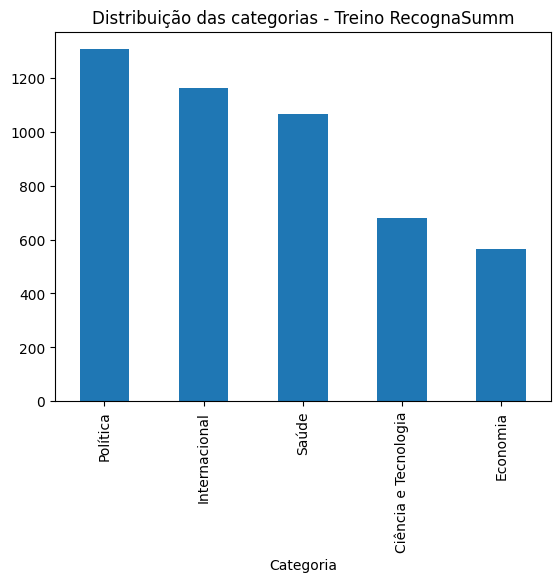

In [ ]:
pd.DataFrame(train_df)['Categoria'].value_counts().plot(kind='bar', title='Distribuição das categorias - Treino RecognaSumm')

In [ ]:
train_df['Categoria'].value_counts()

Categoria
Política                1307
Internacional           1163
Saúde                   1068
Ciência e Tecnologia     679
Economia                 566
Name: count, dtype: int64

In [ ]:
training_set = list(zip(train_df["Noticia"], train_df["Categoria"], train_df["label"]))
test_set = list(zip(test_df["Noticia"], test_df["Categoria"], test_df["label"]))

<Axes: xlabel='Categoria'>

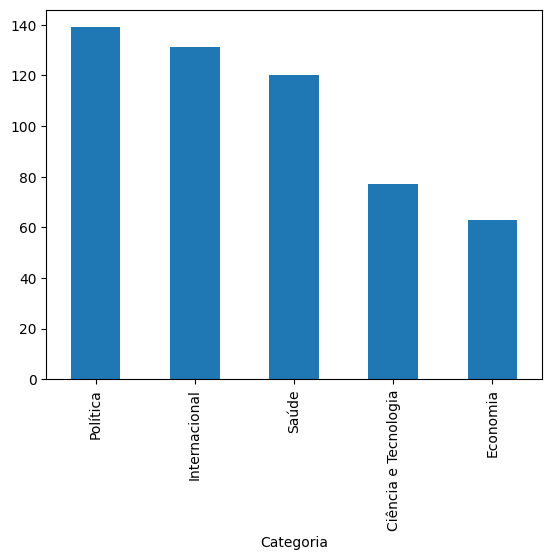

In [ ]:
pd.DataFrame(test_df)['Categoria'].value_counts().plot(kind='bar')

In [ ]:
class_map = {
    "Política": 0,
    "Internacional": 1,
    "Saúde": 2,
    "Ciência e Tecnologia": 3,
    "Economia": 4
}

In [ ]:
train_texts = train_df["Noticia"].to_list()
train_labels = train_df["label"].to_list()

val_texts = valid_df["Noticia"].to_list()
val_labels = valid_df["label"].to_list()

test_texts = test_df["Noticia"].to_list()
test_labels = test_df["label"].to_list()

In [ ]:
train_df

,Noticia,Categoria,label
0,O noticiário está repleto de pessoas que viver...,Ciência e Tecnologia,3
1,Leia mais: Além do risco de levar uma multa po...,Ciência e Tecnologia,3
2,"""Entramos em uma fase de emergência"", disse o ...",Ciência e Tecnologia,3
3,"""Talvez isso soe como ficção científica"", diz ...",Ciência e Tecnologia,3
4,Leia também: Imagem: NASA/JPL-Caltech/Space Sc...,Ciência e Tecnologia,3
...,...,...,...
4778,"""No final de dezembro de 2019, lembro ter pens...",Saúde,2
4779,"O Instituto Butantan, por meio do Centro para ...",Saúde,2
4780,"Nesse cenário, a vacinação do grupo ainda não ...",Saúde,2
4781,O país está sendo atingido por uma segunda ond...,Saúde,2


In [ ]:
train_df['Tamanho'] = train_df['Noticia'].apply(len)
test_df['Tamanho'] = test_df['Noticia'].apply(len)
valid_df['Tamanho'] = valid_df['Noticia'].apply(len)

In [ ]:
train_df

,Noticia,Categoria,label,Tamanho
0,O noticiário está repleto de pessoas que viver...,Ciência e Tecnologia,3,13325
1,Leia mais: Além do risco de levar uma multa po...,Ciência e Tecnologia,3,578
2,"""Entramos em uma fase de emergência"", disse o ...",Ciência e Tecnologia,3,1367
3,"""Talvez isso soe como ficção científica"", diz ...",Ciência e Tecnologia,3,8596
4,Leia também: Imagem: NASA/JPL-Caltech/Space Sc...,Ciência e Tecnologia,3,192
...,...,...,...,...
4778,"""No final de dezembro de 2019, lembro ter pens...",Saúde,2,6300
4779,"O Instituto Butantan, por meio do Centro para ...",Saúde,2,1159
4780,"Nesse cenário, a vacinação do grupo ainda não ...",Saúde,2,2873
4781,O país está sendo atingido por uma segunda ond...,Saúde,2,960


In [ ]:
median_len = train_df['Tamanho'].median()
mean_len = train_df['Tamanho'].mean()

In [ ]:
# Defining pre-processing parameters
max_len = train_df['Tamanho'].max()
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # out of vocabulary token
vocab_size = int(mean_len)

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size,
                      char_level = False,
                      oov_token = oov_tok)
tokenizer.fit_on_texts(train_df['Noticia'])

In [ ]:
word_index = tokenizer.word_index
total_words = len(word_index)
total_words

71775

In [ ]:
training_sequences = tokenizer.texts_to_sequences(train_df['Noticia'])
training_padded = pad_sequences(training_sequences,
                                maxlen = max_len,
                                padding = padding_type,
                                truncating = trunc_type)

In [ ]:
test_sequences = tokenizer.texts_to_sequences(test_df['Noticia'])
test_padded = pad_sequences(test_sequences,
                               maxlen = max_len,
                               padding = padding_type,
                               truncating = trunc_type)

In [ ]:
valid_sequences = tokenizer.texts_to_sequences(valid_df['Noticia'])
valid_padded = pad_sequences(valid_sequences,
                               maxlen = max_len,
                               padding = padding_type,
                               truncating = trunc_type)

In [ ]:
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', test_padded.shape)
print('Shape of testing tensor: ', valid_padded.shape)

Shape of training tensor:  (4783, 32707)
Shape of testing tensor:  (530, 32707)
Shape of testing tensor:  (533, 32707)


In [ ]:
num_classes = 5

### Dense Model

In [ ]:
# Parameters
embedding_dim = 16
drop_value = 0.2
n_dense = 24
# Dense Model Architecture
model = Sequential()
model.add(Embedding(vocab_size,
                    embedding_dim,
                    input_length = max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 32707, 16)         40976     
                                                                 
 global_average_pooling1d_1  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_2 (Dense)             (None, 24)                408       
                                                                 
 dropout_1 (Dropout)         (None, 24)                0         
                                                                 
 dense_3 (Dense)             (None, 5)                 125       
                                                                 
Total params: 41509 (162.14 KB)
Trainable params: 41509 (162.14 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [ ]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam' , metrics = ['accuracy'])

In [ ]:
model_name = "dense_model.keras"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.000001)

In [ ]:
num_epochs = 100
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(training_padded,
                    train_df['label'],
                    epochs=num_epochs,
                    validation_data=(valid_padded, valid_df['label']),
                    callbacks=[checkpoint,earlystopping,learning_rate_reduction],
                    verbose=2)

Epoch 1/100

Epoch 1: val_loss improved from inf to 1.56536, saving model to dense_model.keras
150/150 - 12s - loss: 1.5832 - accuracy: 0.2636 - val_loss: 1.5654 - val_accuracy: 0.2702 - lr: 0.0010 - 12s/epoch - 78ms/step
Epoch 2/100

Epoch 2: val_loss improved from 1.56536 to 1.56387, saving model to dense_model.keras
150/150 - 10s - loss: 1.5657 - accuracy: 0.2710 - val_loss: 1.5639 - val_accuracy: 0.2702 - lr: 0.0010 - 10s/epoch - 69ms/step
Epoch 3/100

Epoch 3: val_loss did not improve from 1.56387
150/150 - 10s - loss: 1.5656 - accuracy: 0.2685 - val_loss: 1.5640 - val_accuracy: 0.2702 - lr: 0.0010 - 10s/epoch - 68ms/step
Epoch 4/100

Epoch 4: val_loss improved from 1.56387 to 1.56349, saving model to dense_model.keras
150/150 - 10s - loss: 1.5653 - accuracy: 0.2674 - val_loss: 1.5635 - val_accuracy: 0.2702 - lr: 0.0010 - 10s/epoch - 67ms/step
Epoch 5/100

Epoch 5: val_loss did not improve from 1.56349
150/150 - 10s - loss: 1.5649 - accuracy: 0.2678 - val_loss: 1.5636 - val_accura

In [ ]:
import matplotlib.pyplot as plt

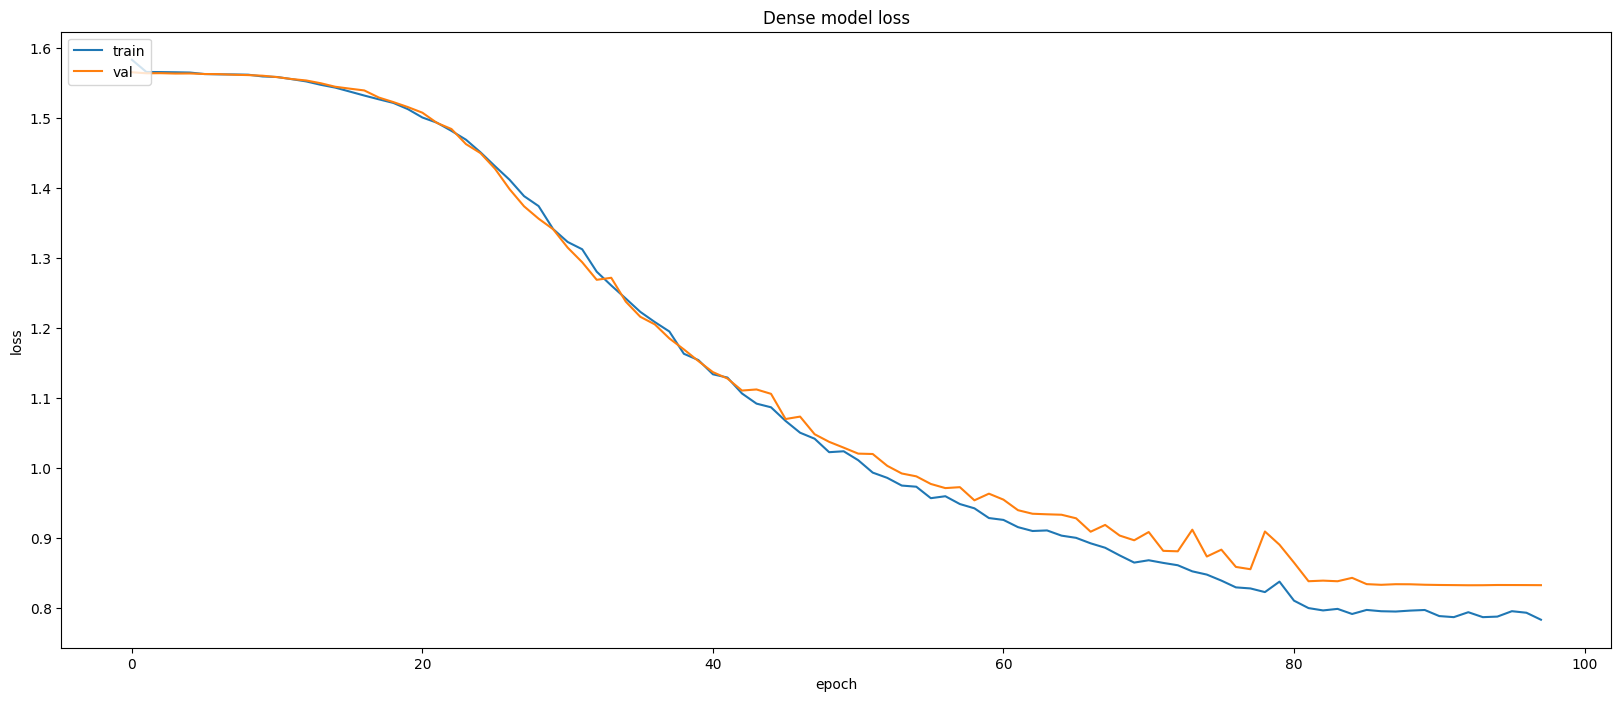

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Dense model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

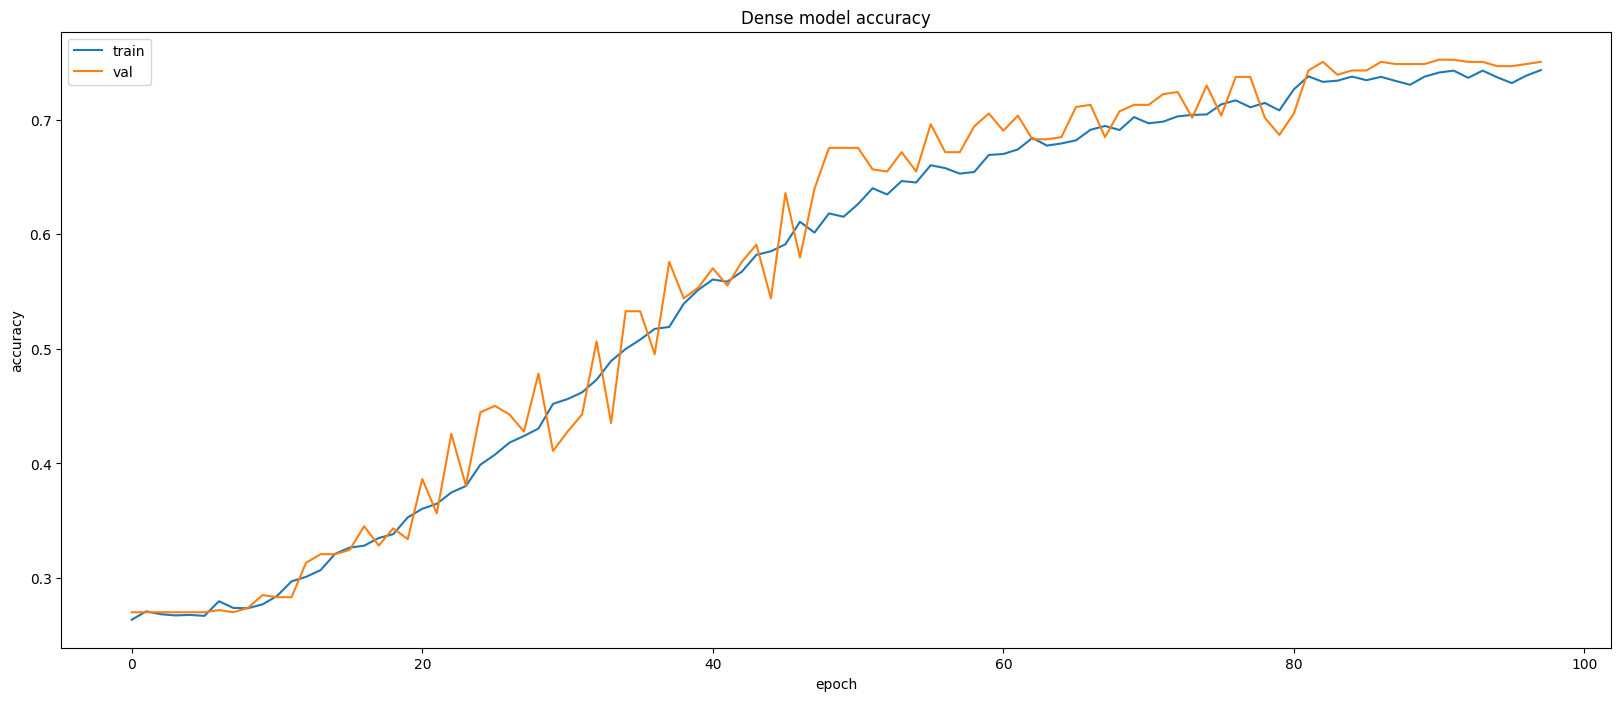

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Dense model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Avaliação do modelo no conjunto de teste
loss, accuracy = model.evaluate(test_padded, test_df['label'])

# Imprimir as métricas
print(f'Loss: {loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')

17/17 [==============================] - 0s 23ms/step - loss: 0.8007 - accuracy: 0.7340
Loss: 0.8007
Accuracy: 0.7340


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Obter as previsões do modelo
predictions = model.predict(test_padded)

# Converter as probabilidades em classes preditas (supondo que seja classificação multiclasse)
predicted_classes = predictions.argmax(axis=1)

# Calcular e imprimir outras métricas
print(classification_report(test_df['label'], predicted_classes))

17/17 [==============================] - 0s 24ms/step
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       139
           1       0.88      0.89      0.88       131
           2       0.65      0.82      0.73       120
           3       0.52      0.57      0.54        77
           4       0.70      0.11      0.19        63

    accuracy                           0.73       530
   macro avg       0.71      0.66      0.64       530
weighted avg       0.74      0.73      0.71       530

